## imports

In [1]:
# https://github.com/tbenst/glia
# please install using `python setup.py develop`
import glia, os, numpy as np, pandas as pd, av, matplotlib.pyplot as plt
from glob import glob
# from tqdm.notebook import tqdm
from tqdm import tqdm

## Drivers

In [2]:
data_directory = "/storage/uw/3brain/200623_faces/"
name = "R1_E3_AMES_200min_200f_14l_rgb"

## Read in files

In [3]:
notebook = glia.find_notebook(data_directory)
lab_notebook = glia.open_lab_notebook(notebook)
experiment_protocol = glia.get_experiment_protocol(lab_notebook, name)

In [4]:
# drop last three numbers to match javascript
date_base = experiment_protocol["date"].isoformat().replace(":", "_")[:-3]
date_base

'2020-06-24T00_01_49.791'

## EPL
see the javascript program that generated the simuli

In [5]:
print(experiment_protocol["epl"])

const metadata = {name: "200faces_14looks", version: "0.2.0"}
const duration = 0.5
const repetitions = 1
const scaleX = 1.125
const scaleY = 1.125
const images = [...Array(200).keys()].map(x => String(1+x))
//  assume format like 8b.jpg
const subImages = [...Array(14).keys()].map(x => String(1+x).padStart(2,"0"))

imageBase = "/images/FEI_Face_200f_14l_rgb/"
imageExt = ".jpg"
imageSrcs = {} // use as Set
// 24 / minute
stimuli = []
let imageSrc = ""
let id, cohort
let meta = {group: r.uuid(), label: "celltype"}
// TODO fixationPoint is broken / unintuitive
let fixationPoint = {x: 600*scaleX/2, y: 360*scaleY/2} // center the 260 x 360 image
const classLabels = ["Person number", "imageNum"]
for (let rep = 0; rep < repetitions; rep++) {
  cohort = r.uuid()
  for (const n of images) {
    for (const s of subImages) {
      id = r.uuid()
      imageSrc = imageBase + n + "-" + s + imageExt
      imageSrcs[imageSrc] = ""
      imageClass = [ n, s ]
      im = new Image(duration, "black", imag

In [6]:
def glob_one_file(path):
    results = glob(path)
    if len(results) == 1:
        return results[0]
    else:
        print("found " + str(len(results)) + " files instead of one for " + path)
        return results
    
stimulus_file = glob_one_file(os.path.join(data_directory, name + ".stim"))
frames_file = glob_one_file(os.path.join(data_directory, date_base + "*.log"))
video_file = glob_one_file(os.path.join(data_directory, date_base + "*.mkv"))

# takes ~30 seconds
metadata, stimulus_list, method = glia.read_stimulus(stimulus_file)
frame_log = pd.read_csv(frames_file)
frame_log = frame_log[:-1] # last frame is not encoded

In [7]:
# read in retinal responses
retinal_data_file = glob_one_file(data_directory+name+"*.npz")
face_npz = np.load(retinal_data_file, allow_pickle=True)
# we will map raw_class using the class resolver
raw_class = face_npz['target']
class_resolver = face_npz['class_resolver'].item()
shape = np.shape(face_npz['data'])
# map target to the look number (0-13)
num2look = {}
# map target to the person number (0-199)
num2person = {}
for class_str, num in class_resolver.items():
    temp = class_str[1:-1].split(", ")
    temp = list(map(lambda x: x.strip("'"), temp))
    image_class = [int(temp[0]), int(temp[1])]
    num2look[num] = image_class[1]
    num2person[num] = image_class[0]

In [8]:
list(face_npz.keys())

['data', 'target', 'class_resolver']

In [9]:
# num_examples x time(ms) x H x W x C
# note that channel here means a spike-sorted unit (purported neuron)
# associated with a particular electrode
# Many channels are all zero, as no unit was found at that channel
# each number is the number of spikes (Action Potentials) in that neuron per ms
# theoretically, with perfect spike sorting, this cannot occur more than once
# every 2-3 ms, but we encode as int8 in case two units are assigned to one channel
face_npz['data'].shape

(2800, 1000, 65, 65, 1)

In [10]:
# num_sizes x num_examples
face_npz['target'].shape

(2800,)

In [11]:
print(np.unique(face_npz['target']))
print(f"a target of 2799 corresponds to person number {num2person[2799]} and look number {num2look[2799]}")

[   0    1    2 ... 2797 2798 2799]
a target of 2799 corresponds to person number 148 and look number 1


In [12]:
frame_log.head()

,framenum,time,stimulusIndex
0,0,46017.434,0
1,1,46034.154,0
2,2,46050.874,0
3,3,46067.594,0
4,4,46084.315,0


## Extract one frame for each image stimuli
This is rather boring data munging--feel free to skip reading the code

In [13]:
# sometimes we drop a frame on the first render of a stimuli, so take the last frame to be conservative
# this index in frame-space
last_frame_idx_of_stimuli = np.concatenate([
    np.where(np.diff(frame_log.stimulusIndex))[0],
    [frame_log.stimulusIndex.iloc[-1]]
])

assert len(stimulus_list) == len(last_frame_idx_of_stimuli)

In [14]:
image_stim = list(filter(
    lambda s: s['stimulus']['stimulusType']=='IMAGE',
    stimulus_list))
image_stim_idx = [s['stimulus']['stimulusIndex']
                         for s in image_stim]

# # take last frame of stimulus as image is static
image_stim_frame_idx = last_frame_idx_of_stimuli[image_stim_idx]

In [15]:
# get first frame from video so we know the size
container = av.open(video_file)
for frame in container.decode(video=0):
    first_frame = frame.to_ndarray(format='bgr24')
    break

H, W, C = first_frame.shape
dtype = first_frame.dtype

In [16]:
# extract people & looks from the stimulus list

people = sorted(list(set(map(
    lambda s: int(s['stimulus']['metadata']['class'][0]),
    image_stim))))
n_people = len(people)

looks = sorted(list(set(map(
    lambda s: int(s['stimulus']['metadata']['class'][1]),
    image_stim))))
n_looks = len(looks)

assert n_people==200
assert n_looks == 14
print(f"Number of faces: {n_people}")
print(f"Number of looks: {n_looks}")

Number of faces: 200
Number of looks: 14


In [17]:
stimulus_list[image_stim_idx[1]]

{'start_time': 7.904830372221008,
 'stimulus': {'age': 0,
  'backgroundColor': 'black',
  'fixationPoint': {'x': 337.5, 'y': 202.5},
  'image': '/images/FEI_Face_200f_14l_rgb/111-11.jpg',
  'lifespan': 0.5,
  'metadata': {'block': 'a728a9ab-77e0-4775-a4f4-a42a5e13ebe7',
   'class': ['111', '11'],
   'classLabels': ['Person number', 'imageNum'],
   'cohort': '44f7450b-402e-4923-9986-495237892703',
   'group': 'a728a9ab-77e0-4775-a4f4-a42a5e13ebe7'},
  'scale': [1.125, 1.125],
  'stimulusIndex': 4,
  'stimulusType': 'IMAGE'}}

In [18]:
assert stimulus_list[image_stim_idx[1]]["stimulus"]['metadata']['classLabels'] \
    == ['Person number', 'imageNum']

In [19]:
# grab only one frame per (person, look)
person_look_to_frame = np.zeros([n_people, n_looks, H, W, C], dtype=dtype)

person_look_set = set()

# map a frame index to (person, look) tuple
# we use only the first frame index to limit
# amount of video we must loop through
idx_to_person_look = {}

person_to_idx = {s: i for i,s in enumerate(people)}

for s in image_stim_idx:
    # note that s is an index in stimulus-space
    stim = stimulus_list[s]
    # images are 1-indexed, so convert to 0-index
    person = int(stim['stimulus']['metadata']['class'][0])-1
    look = int(stim['stimulus']['metadata']['class'][1])-1
    key = (person, look)
    if not key in person_look_set:
        # add to set so lines below occur on earliest frame idx only 
        # for this (person, look)
        person_look_set.add(key)
        # we index by the stimulus idx
        idx = last_frame_idx_of_stimuli[s]
        idx_to_person_look[idx] = key
        
# ensure all person x look combinations are present
assert len(person_look_set)==n_people*n_looks

In [20]:
frame_indices = sorted(list(idx_to_person_look.keys()))
next_frame_idx = frame_indices.pop(0)

# iterate through frames, and match to each entry in frame_indices
# seeking by time would be faster, but does not map 1:1 with frame index
# should take < 1 minute
for n,frame in tqdm(enumerate(container.decode(video=0)),total=frame_indices[-1]):
    if n==(next_frame_idx):
        person, look = idx_to_person_look[next_frame_idx]
        person_look_to_frame[person, look] = frame.to_ndarray(format='bgr24')
        if len(frame_indices)!=0:
            next_frame_idx = frame_indices.pop(0)
        else:
            break

100%|█████████▉| 279566/279576 [04:28<00:00, 995.24it/s]

In [21]:
idx_to_person_look

{61: (40, 1),
 164: (110, 10),
 264: (143, 9),
 365: (65, 11),
 463: (34, 9),
 562: (25, 9),
 657: (105, 4),
 764: (167, 4),
 867: (28, 5),
 963: (125, 1),
 1069: (189, 12),
 1169: (190, 5),
 1276: (188, 13),
 1372: (45, 2),
 1465: (106, 12),
 1560: (52, 1),
 1667: (108, 8),
 1770: (189, 13),
 1877: (61, 11),
 1970: (184, 12),
 2075: (145, 6),
 2170: (136, 10),
 2263: (49, 11),
 2365: (129, 9),
 2462: (32, 9),
 2557: (20, 12),
 2652: (196, 7),
 2757: (129, 1),
 2850: (104, 12),
 2944: (170, 6),
 3045: (175, 0),
 3143: (89, 7),
 3237: (65, 8),
 3342: (178, 4),
 3447: (176, 8),
 3542: (109, 7),
 3640: (118, 12),
 3734: (158, 6),
 3829: (115, 2),
 3935: (43, 8),
 4031: (99, 13),
 4133: (64, 8),
 4231: (137, 13),
 4338: (61, 4),
 4437: (71, 11),
 4541: (142, 4),
 4639: (122, 5),
 4745: (192, 11),
 4843: (198, 13),
 4949: (101, 8),
 5046: (75, 9),
 5141: (119, 9),
 5237: (197, 4),
 5331: (94, 8),
 5432: (91, 10),
 5531: (109, 6),
 5626: (159, 13),
 5726: (78, 1),
 5827: (173, 13),
 5920: (1

In [22]:
def get_frame_for_person_look(person:float, look:str, person_look_to_frame=person_look_to_frame,
                         person_to_idx=person_to_idx):
    "Given the person and the look, return a H x W x C ndarray."
    s = person_to_idx[person]
    l = glia.look_classes[look]
    return person_look_to_frame[s,l]

In [23]:
person

147

In [24]:
look

0

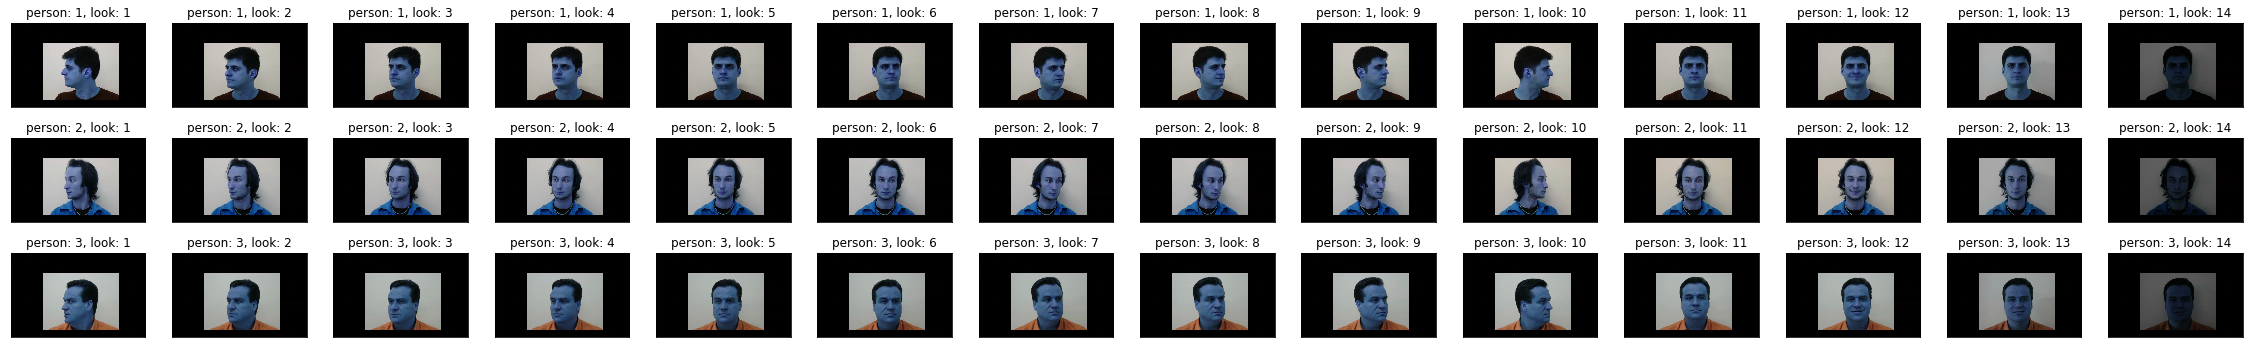

In [25]:
# visualize the person_look_to_frame ndarray for first 3 classes

fig, axes = plt.subplots(3,n_looks, figsize=(40,6))
for p, person in enumerate(people[:3]):
    for l, look in enumerate(looks):
        ax = axes[p,l]
        ax.imshow(person_look_to_frame[person-1, look-1])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"person: {person}, look: {look}")

## SVM classification

In [26]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split

In [27]:
data_bin_100ms = glia.bin_100ms(face_npz["data"][None,None])[0,0]

100%|█████████▉| 279566/279576 [04:40<00:00, 995.24it/s]

## Pixel value inference

In [28]:
import torch, cv2
from torch import nn, optim, utils
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.nn import functional as F
import torchvision.utils
from dataclasses import dataclass

torch.manual_seed(20200525); # reproducible analysis
np.random.seed(seed=20200525)

### data munging

In [29]:
H

800

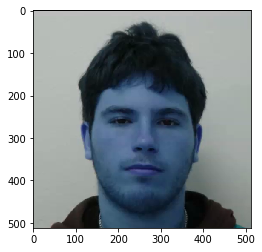

In [30]:
# choose crop parameters
w1 = 409
w2 = W - 359
h1 = 195
h2 = H-93
plt.imshow(person_look_to_frame[-15,10,h1:h2,w1:w2])

In [31]:
assert (512, 512, 3) == person_look_to_frame[-1,3,h1:h2,w1:w2].shape

In [32]:
X = data_bin_100ms.astype(np.float32)
Y = face_npz["target"]

# 90% train, 5% validation, 5% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=1)

# del X, Y

print("(N, T, H, W, C), (N, 2)")
print("train shapes: ", X_train.shape, Y_train.shape)
print("validation shapes: ", X_val.shape, Y_val.shape)
print("test shapes: ", X_test.shape, Y_test.shape)

(N, T, H, W, C), (N, 2)
train shapes:  (2520, 42250) (2520,)
validation shapes:  (140, 42250) (140,)
test shapes:  (140, 42250) (140,)


In [33]:
@dataclass
class FaceData(Dataset):
    X: np.ndarray
    Y: np.ndarray
    person_look_to_frame: np.ndarray
    num2person: dict
    num2look: dict

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        class_num = self.Y[i]
        # switch to 0-index
        look_idx = self.num2look[class_num] - 1
        person_idx = self.num2person[class_num] - 1
        frame = self.person_look_to_frame[person_idx, look_idx]
        return self.X[i], frame
        
def resize_4d(images, fx, fy, interpolation=cv2.INTER_LINEAR, out="ndarray",
        is_tiff=False):
    im = cv2.resize((images[0,0]), None, fx=fx, fy=fy, interpolation=interpolation)
    if out=="ndarray":
        new = np.zeros([images.shape[0],images.shape[1], *im.shape],
            dtype = np.float32)
    elif out=="memmap":
        new = np.memmap("glia_temp_memmap.mmap", np.float32, "w+",
            (images.shape[0],images.shape[1], im.shape[0],im.shape[1]))
    for b, vol in enumerate(images):
        for z, img in enumerate(vol):
            new[b,z] = cv2.resize((img), None, fx=fx, fy=fy,
                interpolation=interpolation)
    return new

def gray_4d(images):
    im = cv2.cvtColor(images[0,0], cv2.COLOR_BGR2GRAY)
    new = np.zeros([images.shape[0],images.shape[1], *im.shape],
            dtype = np.float32)
    for b, vol in enumerate(images):
        for z, img in enumerate(vol):
            new[b,z] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return new

# downsample to 0.5x
small_person_look_to_frame = resize_4d(person_look_to_frame[:,:,h1:h2, w1:w2],1/16,1/16)
# gray-scale (0-1)
small_person_look_to_frame = gray_4d(small_person_look_to_frame) / 255

train_data = FaceData(X_train, Y_train, small_person_look_to_frame, num2person, num2look)
val_data = FaceData(X_val, Y_val, small_person_look_to_frame, num2person, num2look)
test_data = FaceData(X_test, Y_test, small_person_look_to_frame, num2person, num2look)
print(small_person_look_to_frame.shape)

(200, 14, 32, 32)


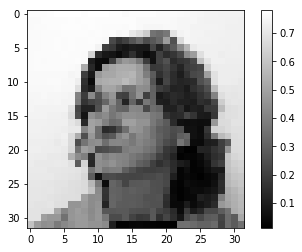

In [34]:
# look at smallest letter with downsampling 
# NOTE: WE SKIP THE SMALLEST
plt.imshow(small_person_look_to_frame[20,1], cmap="gray")
plt.colorbar()
small_H, small_W = small_person_look_to_frame[0,1].shape

In [35]:
X_train.dtype

dtype('float32')

###  variational autoencoder

In [36]:
# whether or not to use cuda
device = torch.device("cuda")

In [37]:
# Kingma & Welling (2014) style variational autoencoder

# subclass PyTorch Module for reverse-mode autodifferentiation 
# for easy backpropogation of loss gradient
class VAE(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_latent, n_hidden2, n_output,
                 nonlinearity=F.sigmoid):
        super(VAE, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hidden = n_hidden
        self.nonlinearity = F.sigmoid
                
        # Encoder layers
        self.hidden_encoder = nn.Linear(n_input, n_hidden)
        # mean encoding layer 
        self.mean_encoder = nn.Linear(n_hidden, n_latent)
        # log variance encoding layer 
        self.logvar_encoder = nn.Linear(n_hidden, n_latent)
        
        # Decoder layers
        self.hidden_decoder = nn.Linear(n_latent, n_hidden2)
        self.reconstruction_decoder = nn.Linear(n_hidden2, n_output)

    def encode(self, x):
        h1 = self.nonlinearity(self.hidden_encoder(x))
        return self.mean_encoder(h1), self.logvar_encoder(h1)

    def reparameterize(self, mean, logvar):
        """Reparameterize out stochastic node so the gradient can propogate 
           deterministically."""

        if self.training:
            standard_deviation = torch.exp(0.5*logvar)
            # sample from unit gaussian with same shape as standard_deviation
            epsilon = torch.randn_like(standard_deviation)
            return epsilon * standard_deviation + mean
        else:
            return mean

    def decode(self, z):
        h3 = self.nonlinearity(self.hidden_decoder(z))
        # bound output to (0,1)
        return F.sigmoid(self.reconstruction_decoder(h3))

    
    def forward(self, x):
        "A special method in PyTorch modules that is called by __call__"
        mean, logvar = self.encode(x)
        # sample an embedding, z
        z = self.reparameterize(mean, logvar)
        # return the (sampled) reconstruction, mean, and log variance
        return self.decode(z), mean, logvar



def loss_function(recon_y, y, mu, logvar, beta=1):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    BCE = F.binary_cross_entropy(recon_y, y, size_average=False)

    # we want KLD = - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma is standard deviation and mu is mean
    # (see Appendix B of https://arxiv.org/abs/1312.6114)
    
    # see https://openreview.net/forum?id=Sy2fzU9gl for info on choosing Beta
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


    return BCE + beta * KLD

In [38]:
def train(epoch, model, optimizer, train_loader, beta=1., log_interval=10):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        bz = data[0].shape[0]
        # flatten batch x height x width x channel into batch x nFeatures
        X = data[0].reshape(bz, -1).to(device)
        Y = data[1].reshape(bz, -1).to(device) # flatten
        optimizer.zero_grad()
        Y_pred, mu, logvar = model(X)
        loss = loss_function(Y_pred, Y, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % log_interval == 0:
        print('Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))


def test(epoch, model, test_loader, H, W, beta=1., log_interval=10,
         save_image=True, folder="results", name="Test"):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            bz = data[0].shape[0]
            
            # flatten batch x height x width x channel into batch x nFeatures
            X = data[0].reshape(bz, -1).to(device)
            Y = data[1].reshape(bz, -1).to(device) # flatten

            Y_pred, mu, logvar = model(X)
            test_loss += loss_function(Y_pred, Y, mu, logvar).item()
            if (i == 0) and save_image:
                n = min(X.size(0), 15)
                comparison = torch.cat([Y[:n].view(-1,1,H,W),
                                   Y_pred[:n].view(-1, 1, H, W)])
                torchvision.utils.save_image(comparison.cpu(),
                         folder+f'/{name}_reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    if epoch % log_interval == 0:
        print(f'====> {name} ' + 'set loss: {:.4f}'.format(test_loss))



In [39]:
train_loader = DataLoader(train_data,
    batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data,
    batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data,
    batch_size=64, shuffle=True, pin_memory=True)

nfeatures = 28**2
# we use a latent space of dimension 2 as to get an easy-to-visualize manifold
# (see mnist/sample_*.png while running next cell)
n_input = np.prod(X_train.shape[1:])
n_hidden = 1000
n_latent = 2
n_hidden2 = 1000
beta = 10
lr = 8e-4
nonlinearity = F.celu
n_output = np.product(small_person_look_to_frame.shape[2:])
est_params = n_input*n_hidden + n_hidden*n_latent + n_latent*n_hidden2 + n_hidden2*n_output
print(est_params)

model = VAE(n_input, n_hidden, n_latent, n_hidden2, n_output,
            nonlinearity=nonlinearity).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
!mkdir -p letters_viz && rm letters_viz/*

# this will take two minutes to run or so
# As it does, check out the letters_viz folder!
# each epoch, reconstruction examples are saved (original on top) 
# select files on right, then refresh, and double click image
# click bottom right corner of image to resize

nepochs = 100

# make grid of z1 x z2 where z1,z2 \elem (-3.5,-2.5, ..., 3.5)
nrow = 25
latents = torch.zeros(nrow,nrow,n_latent)
z1_tick = np.linspace(-3.5,3.5,nrow)
z2_tick = np.linspace(-3.5,3.5,nrow)
for i, z1 in enumerate(z1_tick):
    for j, z2 in enumerate(z2_tick):
        latents[i,j,[0,1]] = torch.tensor([z1,z2])
latents = latents.to(device)

for epoch in range(1, nepochs + 1):
    if epoch % 10 == 0:
        save_image = True
    else:
        save_image = False
    train(epoch, model, optimizer, train_loader, beta=beta)
    test(epoch, model, val_loader, small_H, small_W, beta=beta,
         save_image=save_image, folder='letters_viz', name="Validation")
    if save_image:
        with torch.no_grad():
            latent_space = model.decode(latents.view(-1,n_latent)).cpu()
            torchvision.utils.save_image(latent_space.view(-1, 1, small_H, small_W),
                       'letters_viz/sample_' + str(epoch) + '.png',nrow=nrow)

43278000


/home/tyler/lib/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/tyler/lib/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 10 Average loss: 601.9948
====> Validation set loss: 602.7552
Epoch: 20 Average loss: 601.1367
====> Validation set loss: 602.4840
Epoch: 30 Average loss: 597.8306
====> Validation set loss: 599.5102
Epoch: 40 Average loss: 596.4268
====> Validation set loss: 599.3304
Epoch: 50 Average loss: 595.4348
====> Validation set loss: 599.4975
Epoch: 60 Average loss: 594.8335
====> Validation set loss: 598.4374
Epoch: 70 Average loss: 594.3458
====> Validation set loss: 598.6598
Epoch: 80 Average loss: 593.8073
====> Validation set loss: 598.3328
Epoch: 90 Average loss: 593.3142
====> Validation set loss: 598.1688
Epoch: 100 Average loss: 592.8823
====> Validation set loss: 597.6714


In [40]:
test(epoch, model, test_loader, small_H, small_W, beta=beta,
         save_image=save_image, folder='letters_viz', name="Test")

====> Test set loss: 598.3467
